# Bu kod **36 veri** ile **Google Colab** üzerinden örnek olarak çalıştırılmıştır. Başarılı sorunçlar için veri sayısı, epoch, batch_size değerleri değiştirilmelidir.

In [ ]:
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras

In [ ]:
pip install simpleitk

In [ ]:
!unzip /content/Örnek_veri.zip

Archive:  /content/Örnek_veri_.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/Örnek_veri_.zip or
        /content/Örnek_veri_.zip.zip, and cannot find /content/Örnek_veri_.zip.ZIP, period.


In [ ]:
yol = '/content/data_training/HGG/'

In [ ]:
import os
os.listdir(yol)

['BraTS19_CBICA_ANI_1',
 'BraTS19_CBICA_ABM_1',
 'BraTS19_CBICA_ANP_1',
 'BraTS19_CBICA_AAP_1',
 'BraTS19_2013_18_1',
 'BraTS19_CBICA_AOO_1',
 'BraTS19_CBICA_ANG_1',
 'BraTS19_CBICA_ABO_1',
 'BraTS19_CBICA_AAL_1',
 'BraTS19_CBICA_AOS_1',
 'BraTS19_CBICA_ABB_1',
 'BraTS19_CBICA_AAG_1',
 'BraTS19_CBICA_AMH_1',
 'BraTS19_2013_26_1',
 'BraTS19_CBICA_AOH_1',
 'BraTS19_CBICA_AOP_1',
 'BraTS19_CBICA_AOZ_1',
 'BraTS19_2013_23_1',
 'BraTS19_CBICA_AOC_1',
 'BraTS19_CBICA_ABE_1',
 'BraTS19_CBICA_ABY_1',
 'BraTS19_2013_25_1',
 'BraTS19_CBICA_AAB_1',
 'BraTS19_2013_19_1',
 'BraTS19_CBICA_AME_1',
 'BraTS19_CBICA_ALN_1',
 'BraTS19_CBICA_ALU_1',
 'BraTS19_CBICA_AOD_1',
 'BraTS19_CBICA_ANZ_1',
 'BraTS19_2013_22_1',
 'BraTS19_CBICA_ANV_1',
 'BraTS19_CBICA_ABN_1',
 'BraTS19_CBICA_ALX_1',
 'BraTS19_2013_20_1',
 'BraTS19_2013_21_1',
 'BraTS19_2013_27_1']

In [ ]:
len(os.listdir(yol))

36

In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!


def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!

In [ ]:
flair=train_array(yol,'**/*flair.nii.gz')
t2=train_array(yol,'**/*t2.nii.gz')
seg = seg_array(yol,'**/*seg.nii.gz',1)
seg_orj = seg_array(yol,'**/*seg.nii.gz',1)

In [ ]:
flair.shape, seg.shape, t2.shape

((2520, 1, 240, 240), (2520, 1, 240, 240), (2520, 1, 240, 240))

In [ ]:
flair.dtype, seg.dtype, t2.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [ ]:
x_train = np.concatenate((flair,t2),axis=1)
x_train.dtype, x_train.shape

(dtype('float32'), (2520, 2, 240, 240))

In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 0.005 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

model = unet_model()

In [ ]:
model.fit(x_train,seg,validation_split=0.20,batch_size=1,epochs=1,shuffle=True,verbose=1)

Epoch 1/3
1008/1008 [==============================] - 148s 137ms/step - loss: 0.7904 - dice_coef: 0.2096 - val_loss: 0.5651 - val_dice_coef: 0.4349
Epoch 2/3
1008/1008 [==============================] - 141s 140ms/step - loss: 0.4659 - dice_coef: 0.5341 - val_loss: 0.5357 - val_dice_coef: 0.4643
Epoch 3/3
1008/1008 [==============================] - 142s 141ms/step - loss: 0.3328 - dice_coef: 0.6672 - val_loss: 0.5760 - val_dice_coef: 0.4240


In [ ]:
seg_geniş   = seg_array(yol,'**/*seg.nii.gz',4)
seg_ödemsiz = seg_array(yol,'**/*seg.nii.gz',3)

In [ ]:
t1ce = train_array(yol,'**/*t1ce.nii.gz')

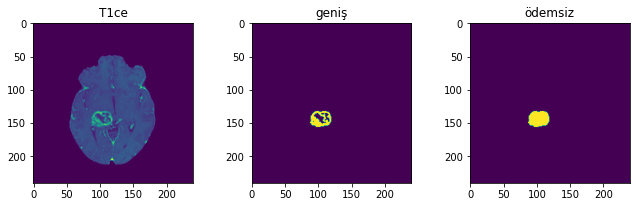

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce[285,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(seg_geniş[285,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(seg_ödemsiz[285,0,:,:])

In [ ]:

liste_t1ce = []
liste_geniş = []
liste_ödemsiz = []

for i in range(len(seg_ödemsiz)):
    img = tümör_kırpma(t1ce[i],seg_ödemsiz[i])
    if len(img.shape) > 2:
        liste_t1ce.append(img)
        print(f'{i}')

for i in range(len(seg_ödemsiz)):
    img = tümör_kırpma(seg_geniş[i],seg_ödemsiz[i])
    if len(img.shape) > 2:
        liste_geniş.append(img)
        print(f'{i}')

for i in range(len(seg_ödemsiz)):
    img = tümör_kırpma(seg_ödemsiz[i],seg_ödemsiz[i])
    if len(img.shape) > 2:
        liste_ödemsiz.append(img)
        print(f'{i}')        

In [ ]:
ödemsiz = np.array(liste_ödemsiz)
geniş = np.array(liste_geniş)
t1ce_kırp = np.array(liste_t1ce)

In [ ]:
t1ce_kırp.shape, ödemsiz.shape, geniş.shape

((1162, 1, 64, 64), (1162, 1, 64, 64), (1162, 1, 64, 64))

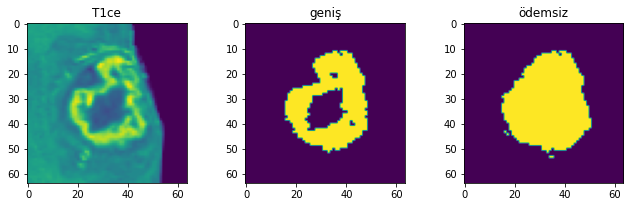

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[405,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş[405,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz[405,0,:,:])

In [ ]:
def unet_model_7():
    
    inputs = Input((1, 64, 64))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
     
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch5)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
model_ödemsiz = unet_model_7()

In [ ]:
history = model_ödemsiz.fit(t1ce_kırp, ödemsiz,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
93/93 [==============================] - 4s 39ms/step - loss: 0.0837 - dice_coef: 0.9164 - val_loss: 0.3591 - val_dice_coef: 0.6223
Epoch 2/5
93/93 [==============================] - 4s 39ms/step - loss: 0.0732 - dice_coef: 0.9268 - val_loss: 0.4340 - val_dice_coef: 0.5496
Epoch 3/5
93/93 [==============================] - 4s 39ms/step - loss: 0.0756 - dice_coef: 0.9242 - val_loss: 0.4646 - val_dice_coef: 0.5362
Epoch 4/5
93/93 [==============================] - 4s 39ms/step - loss: 0.0709 - dice_coef: 0.9292 - val_loss: 0.3860 - val_dice_coef: 0.6113
Epoch 5/5
93/93 [==============================] - 4s 39ms/step - loss: 0.0576 - dice_coef: 0.9424 - val_loss: 0.5226 - val_dice_coef: 0.4779


In [ ]:
model_geniş = unet_model_7()

In [ ]:
history = model_geniş.fit(t1ce_kırp, geniş,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
93/93 [==============================] - 4s 40ms/step - loss: 0.1963 - dice_coef: 0.8037 - val_loss: 0.3980 - val_dice_coef: 0.5844
Epoch 2/5
93/93 [==============================] - 4s 40ms/step - loss: 0.1833 - dice_coef: 0.8168 - val_loss: 0.4840 - val_dice_coef: 0.5010
Epoch 3/5
93/93 [==============================] - 4s 40ms/step - loss: 0.1641 - dice_coef: 0.8358 - val_loss: 0.5366 - val_dice_coef: 0.4499
Epoch 4/5
93/93 [==============================] - 4s 40ms/step - loss: 0.1495 - dice_coef: 0.8505 - val_loss: 0.4603 - val_dice_coef: 0.5240
Epoch 5/5
93/93 [==============================] - 4s 40ms/step - loss: 0.1359 - dice_coef: 0.8639 - val_loss: 0.4963 - val_dice_coef: 0.4891


In [ ]:
model_ödemsiz.load_weights('/content/ödemsiz.h5')
model_geniş.load_weights('/content/geniş.h5')

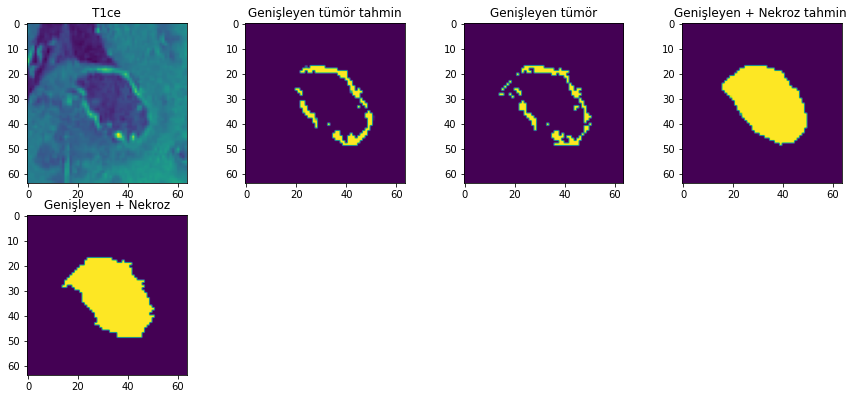

In [ ]:
x = 235

plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('T1ce')
plt.imshow(t1ce_kırp[x,0,:,:])


pred_geniş = model_geniş.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,2)
plt.title('Genişleyen tümör tahmin')
plt.imshow(pred_geniş[0,0,:,:] )

plt.subplot(3,4,3)
plt.title('Genişleyen tümör')
plt.imshow(geniş[x,0,:,:])

pred_ödemsiz = model_ödemsiz.predict(t1ce_kırp[x:x+1,:,:,:])
plt.subplot(3,4,4)
plt.title('Genişleyen + Nekroz tahmin ')
plt.imshow(pred_ödemsiz[0,0,:,:] )


plt.subplot(3,4,5)
plt.title('Genişleyen + Nekroz')
plt.imshow(ödemsiz[x,0,:,:])

In [ ]:
def tümör_kırp(x, pred, size): 
    crop_x = []
    list_xy = []
    p_tmp = pred[0,:,:]
    p_tmp[p_tmp>0.2] = 1    
    p_tmp[p_tmp !=1] = 0
    index_xy = np.where(p_tmp==1)  

    if index_xy[0].shape[0] == 0: 
        return [],[]
        
    center_x = (max(index_xy[0]) + min(index_xy[0])) / 2 
    center_y = (max(index_xy[1]) + min(index_xy[1])) / 2 
    
    if center_x >= 176:
            center_x = center_x-8
        
    length = max(index_xy[0]) - min(index_xy[0])
    width = max(index_xy[1]) - min(index_xy[1])
        
    if width <= 64 and length <= 64:  #64x64
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size/2)))
            
    if width > 64 and length <= 64:  #64x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size/2) : int(center_x + size/2),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size/2),int(center_y)))
            
    if width <= 64 and length > 64:  #128x64       
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size/2)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size/2) : int(center_y + size/2)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size/2)))
            
    if width > 64 and length > 64:  #128x128
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y - size) : int(center_y)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y - size)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x - size) : int(center_x),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x - size),int(center_y)))
            
        img_x = np.zeros((1,size,size),np.float32)
        img_x[:,:,:] = x[:,int(center_x + 1) : int(center_x + size + 1),int(center_y + 1) : int(center_y + size + 1)]
        crop_x.append(img_x)
        list_xy.append((int(center_x),int(center_y)))
        
    
        
    return np.array(crop_x) , list_xy   

In [ ]:
görüntü1, kordinat1 = tümör_kırp(t1ce[90,:,:,:],seg[90,:,:,:],64)
görüntü2, kordinat2 = tümör_kırp(seg_geniş[90,:,:,:],seg[90,:,:,:],64)
görüntü3, kordinat3 = tümör_kırp(seg_ödemsiz[90,:,:,:],seg[90,:,:,:],64)

In [ ]:
görüntü1.shape, görüntü2.shape, görüntü3.shape

((4, 1, 64, 64), (4, 1, 64, 64), (4, 1, 64, 64))

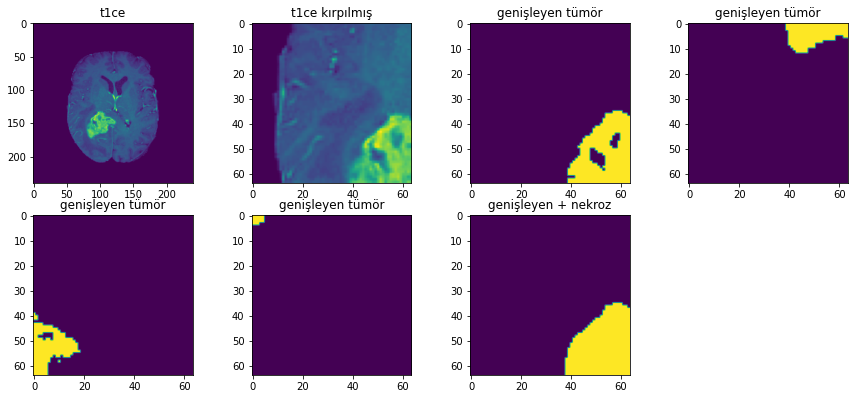

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce[90,0,:,:])

plt.subplot(3,4,2)
plt.title('t1ce kırpılmış')
plt.imshow(görüntü1[0,0,:,:])

plt.subplot(3,4,3)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[0,0,:,:])

plt.subplot(3,4,4)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[1,0,:,:])

plt.subplot(3,4,5)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[2,0,:,:])

plt.subplot(3,4,6)
plt.title('genişleyen tümör')
plt.imshow(görüntü2[3,0,:,:])

plt.subplot(3,4,7)
plt.title('genişleyen + nekroz')
plt.imshow(görüntü3[0,0,:,:])

In [ ]:
liste = []

for i in range(len(t1ce)):
    crop , kordinat = tümör_kırp(seg_ödemsiz[i,:,:,:],seg[i,:,:,:],64)
    
    if crop == []:
        pass
    elif crop.shape[0] ==1:
        liste.append(crop[0])
        
    elif crop.shape[0] ==2:
        
        liste.append(crop[0])
        liste.append(crop[1])
        
    elif crop.shape[0] ==4:
        
        liste.append(crop[0])
        liste.append(crop[1])
        liste.append(crop[2])
        liste.append(crop[3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


In [ ]:
t1ce_array = np.array(liste)

In [ ]:
geniş_array = np.array(liste)

In [ ]:
ödemsiz_array = np.array(liste)

In [ ]:
t1ce_array.shape, ödemsiz_array.shape, geniş_array.shape

((2973, 1, 64, 64), (2973, 1, 64, 64), (2973, 1, 64, 64))

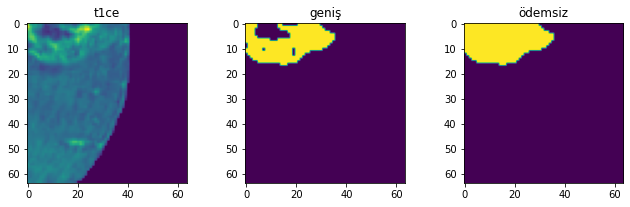

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(3,4,1)
plt.title('t1ce')
plt.imshow(t1ce_array[90,0,:,:])

plt.subplot(3,4,2)
plt.title('geniş')
plt.imshow(geniş_array[90,0,:,:])

plt.subplot(3,4,3)
plt.title('ödemsiz')
plt.imshow(ödemsiz_array[90,0,:,:])

In [ ]:
model_ödemsiz_2 = unet_model_7()

In [ ]:
history = model_ödemsiz_2.fit(t1ce_array, ödemsiz_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
238/238 [==============================] - 12s 46ms/step - loss: 0.6735 - dice_coef: 0.3265 - val_loss: 0.7141 - val_dice_coef: 0.2836
Epoch 2/5
238/238 [==============================] - 10s 40ms/step - loss: 0.3594 - dice_coef: 0.6406 - val_loss: 0.5319 - val_dice_coef: 0.4642
Epoch 3/5
238/238 [==============================] - 9s 40ms/step - loss: 0.2543 - dice_coef: 0.7457 - val_loss: 0.5431 - val_dice_coef: 0.4531
Epoch 4/5
238/238 [==============================] - 9s 39ms/step - loss: 0.1937 - dice_coef: 0.8063 - val_loss: 0.5151 - val_dice_coef: 0.4808
Epoch 5/5
238/238 [==============================] - 9s 39ms/step - loss: 0.1572 - dice_coef: 0.8428 - val_loss: 0.5480 - val_dice_coef: 0.4482


In [ ]:
model_geniş_2 = unet_model_7()

In [ ]:
history = model_geniş_2.fit(t1ce_array, geniş_array,
                       validation_split= 0.20,
                       batch_size = 10,
                       epochs= 5,
                       shuffle=True,
                       verbose=1)

Epoch 1/5
238/238 [==============================] - 11s 40ms/step - loss: 0.7825 - dice_coef: 0.2175 - val_loss: 0.8084 - val_dice_coef: 0.1900
Epoch 2/5
238/238 [==============================] - 9s 39ms/step - loss: 0.5800 - dice_coef: 0.4200 - val_loss: 0.5344 - val_dice_coef: 0.4618
Epoch 3/5
238/238 [==============================] - 9s 39ms/step - loss: 0.4251 - dice_coef: 0.5749 - val_loss: 0.5748 - val_dice_coef: 0.4216
Epoch 4/5
238/238 [==============================] - 9s 39ms/step - loss: 0.3471 - dice_coef: 0.6529 - val_loss: 0.5161 - val_dice_coef: 0.4798
Epoch 5/5
238/238 [==============================] - 9s 39ms/step - loss: 0.2778 - dice_coef: 0.7222 - val_loss: 0.5312 - val_dice_coef: 0.4649


In [ ]:
model_ödemsiz_2.load_weights('/content/ödemsiz.h5')
model_geniş_2.load_weights('/content/geniş.h5')
model.load_weights('/content/tam.h5')

In [ ]:
görüntü , koordinat = tümör_kırp(t1ce[90,:,:,:],seg[90,:,:,:],64)

In [ ]:
görüntü.shape

(4, 1, 64, 64)

In [ ]:
pred_ödemsiz = model_ödemsiz.predict(görüntü)
pred_geniş = model_geniş.predict(görüntü)
pred_tam = model.predict(x_train[90:91,:,:,:])

In [ ]:
pred_tam[pred_tam > 0.2] = 2
pred_tam[pred_tam != 2 ] = 0

pred_ödemsiz[pred_ödemsiz > 0.2] = 1
pred_ödemsiz[pred_ödemsiz != 1 ] = 0

pred_geniş[pred_geniş > 0.2] = 4
pred_geniş[pred_geniş != 4 ] = 0

In [ ]:
def üstüne_ekle(pred_tam, pred_ödemsiz , pred_geniş , koordinat):  
    
    total = np.zeros((1,240,240),np.float32)  
    total[:,:,:] = pred_tam[:,:,:]
    
    for i in range(pred_ödemsiz.shape[0]):
        for j in range(64):
            for k in range(64):
                
                if pred_ödemsiz[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_ödemsiz[i,0,j,k]
                    
                if pred_geniş[i,0,j,k] != 0 and pred_tam[0,koordinat[i][0]+j,koordinat[i][1]+k] !=0:
                    total[0,koordinat[i][0]+j,koordinat[i][1]+k] = pred_geniş[i,0,j,k]
                
    return total

In [ ]:
deneme = üstüne_ekle(pred_tam[0,:,:,:], pred_ödemsiz, pred_geniş, koordinat)

In [ ]:
deneme.shape

(1, 240, 240)

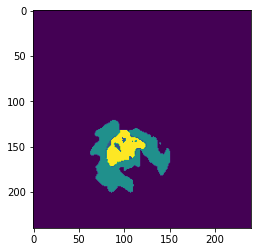

In [ ]:
plt.imshow(deneme[0])

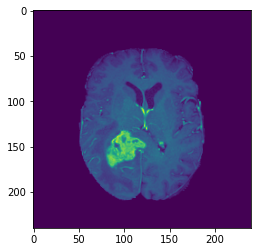

In [ ]:
plt.imshow(t1ce[90,0,:,:])